In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import sys
sys.path.append('../scripts')  # Appending the path to access the scripts folder
from Model_Training import * 

In [4]:
# Step 1: Load the data
# Assuming 'merged_data' is the merged DataFrame containing Brent oil prices and economic indicators
# Load data (update path as needed)
data_path = 'C:/Users/Administrator/Documents/kifiya/Week_10/data/Merged_brent_oil_prices_with_Indicators.csv'
merged_data = pd.read_csv(data_path, parse_dates=['Date'])
merged_data.set_index('Date', inplace=True)

# Step 2: Drop non-numeric columns
merged_data = merged_data.select_dtypes(include=[np.number])

# Step 3: Handle missing values
merged_data.fillna(method='ffill', inplace=True)  # Forward-fill any missing values
merged_data.dropna(inplace=True)  # Drop rows with any remaining NaN values

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2928\3903032823.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='ffill', inplace=True)  # Forward-fill any missing values


In [5]:
# Step 4: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(merged_data.values)

# Step 5: Create sequences for the LSTM
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])  # All features as input sequence
        y.append(data[i + look_back, 0])    # Brent oil price as target
    return np.array(X), np.array(y)

look_back = 60  # Sequence length
X, y = create_sequences(data_scaled, look_back)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 6: Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [6]:
# Model parameters
input_size = X.shape[2]  # Number of features
hidden_size = 50
num_layers = 2
output_size = 1

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Step 8: Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

c:\Users\Administrator\miniconda3\envs\jojo\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([330])) that is different to the input size (torch.Size([330, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.1367
Epoch [2/10], Loss: 0.0752
Epoch [3/10], Loss: 0.0549
Epoch [4/10], Loss: 0.0578
Epoch [5/10], Loss: 0.0643
Epoch [6/10], Loss: 0.0628
Epoch [7/10], Loss: 0.0581
Epoch [8/10], Loss: 0.0545
Epoch [9/10], Loss: 0.0536
Epoch [10/10], Loss: 0.0544


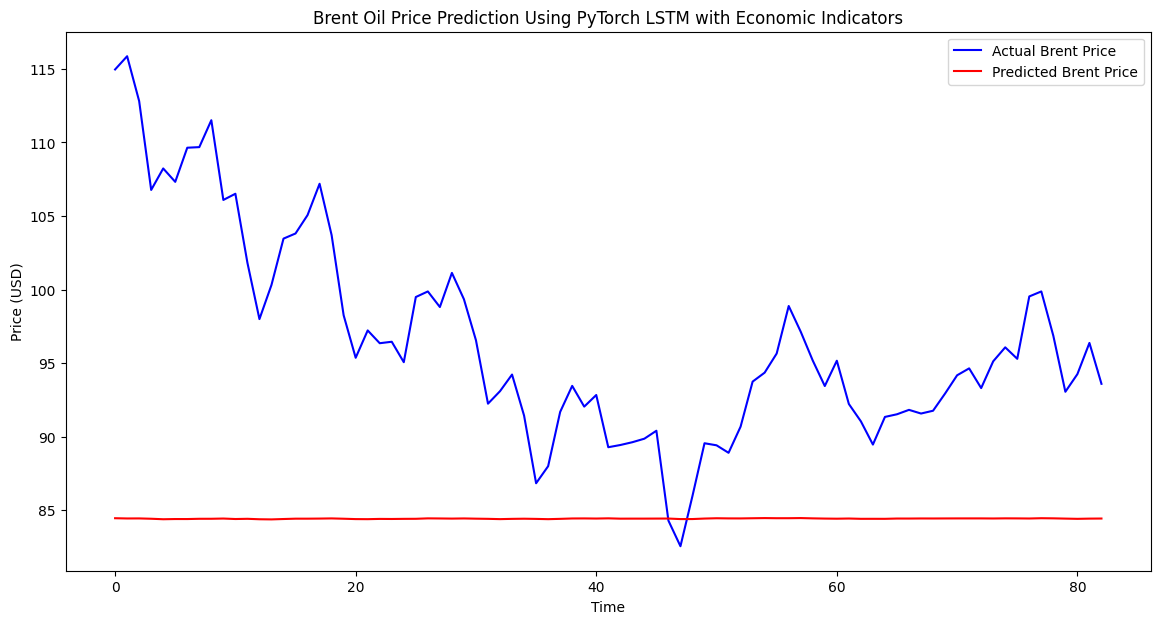

In [8]:
# Step 9: Make predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# Step 10: Inverse transform the predictions and actual values
train_pred = train_pred.numpy()
test_pred = test_pred.numpy()
y_train = y_train.numpy()
y_test = y_test.numpy()

# Inverse transform using scaler
train_pred = scaler.inverse_transform(np.concatenate([train_pred, np.zeros((train_pred.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]
test_pred = scaler.inverse_transform(np.concatenate([test_pred, np.zeros((test_pred.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]
y_train_actual = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data_scaled.shape[1] - 1))], axis=1))[:, 0]

# Step 11: Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Brent Price', color='blue')
plt.plot(test_pred, label='Predicted Brent Price', color='red')
plt.title('Brent Oil Price Prediction Using PyTorch LSTM with Economic Indicators')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
